In [6]:
import pandas as pd
import numpy as np

In [7]:
column_names = ['Order_id','Segment','Hour_start','Type','Quantity','Price','Hour_Covered']

In [50]:
df = pd.read_csv('./Epias/test1.csv', header=None, names = column_names)

In [51]:
df

,Order_id,Segment,Hour_start,Type,Quantity,Price,Hour_Covered
0,12,1,1,S,200,0,1
1,12,2,1,S,60,80,1
2,12,3,1,S,0,100,1
3,11,1,1,S,-20,0,1
4,11,2,1,S,-100,40,1
5,11,3,1,S,-180,100,1


In [52]:
#定义order_id（订单的集合）
Order_id = np.unique(df.loc[:,'Order_id'])
Order_id

array([11, 12], dtype=int64)

In [53]:
#定义S（set of supply bids）和T（set of demand bids）
S = [];
T = [];
for i in Order_id:
    if sum(df[df.loc[:,'Order_id']==i].iloc[:,4]) > 0:
        T.append(i);
    else:
        S.append(i);

In [54]:
print(T)
print(S)

[12]
[11]


In [55]:
max(df['Hour_start'].values+df['Hour_Covered'].values)

2

In [56]:
#定义Z（set of time periods）
Z = np.arange(min(df['Hour_start'].tolist()), max(df['Hour_start'].values+df['Hour_Covered'].values))
print(Z)

[1]


In [57]:
np.unique(df[df.loc[:,'Hour_start']==1]['Order_id'])

array([11, 12], dtype=int64)

In [58]:
#定义T时段内的bid id(后续需要针对block进行改动)
bid_z = {}
for z in Z:
    tlist = [];
    slist = [];
    for i in np.unique(df[df.loc[:,'Hour_start']==z]['Order_id']):
        if sum(df[df.loc[:,'Order_id']==i].iloc[:,4]) > 0:
            tlist.append(i);
        else:
            slist.append(i);
    bid_z[z] = [tlist,slist]
print(bid_z)

{1: [[12], [11]]}


In [59]:
df[df.loc[:,'Order_id'] == 12]

,Order_id,Segment,Hour_start,Type,Quantity,Price,Hour_Covered
0,12,1,1,S,200,0,1
1,12,2,1,S,60,80,1
2,12,3,1,S,0,100,1


In [60]:
df[df.loc[:,'Order_id']==12].loc[:,['Quantity','Price']]

,Quantity,Price
0,200,0
1,60,80
2,0,100


In [61]:
df[df.loc[:,'Order_id']==12]['Quantity'].tolist()

[200, 60, 0]

In [62]:
df[df.loc[:,'Order_id']==12].loc[:,['Segment']].values[-1][0]

3

In [63]:
#定义L （set of segment information）
#{id:[segment number,quantity list,price list]}
L_adj = {}
for i in Order_id:
    L_adj[i] = [df[df.loc[:,'Order_id']==i].loc[:,['Segment']].values[-1][0]-1 , df[df.loc[:,'Order_id']==i]['Quantity'].tolist() , df[df.loc[:,'Order_id']==i]['Price'].tolist()]
print(L_adj)

{11: [2, [-20, -100, -180], [0, 40, 100]], 12: [2, [200, 60, 0], [0, 80, 100]]}


In [64]:
L= {}
for i in T:
    L[i] = [L_adj[i][0] , L_adj[i][1][::-1] , L_adj[i][2][::-1]]
for i in S:
    L[i] = [L_adj[i][0] , [-num for num in L_adj[i][1]] , L_adj[i][2]]
print(L)

{12: [2, [0, 60, 200], [100, 80, 0]], 11: [2, [20, 100, 180], [0, 40, 100]]}


In [65]:
max(df[df.loc[:,'Hour_start']==1]['Price'].tolist())

100

In [66]:
#定义Fmax和Fmin
F = {}
for z in Z:
    if len(df[df.loc[:,'Hour_start']==z]['Price'].tolist()) > 0:
        F[z] = [min(df[df.loc[:,'Hour_start']==1]['Price'].tolist()),max(df[df.loc[:,'Hour_start']==1]['Price'].tolist())]
    else:
        F[z] = [0,0]
print(F)

{1: [0, 100]}


In [67]:
#定义模型
import gurobipy as gp
from gurobipy import GRB

# Initialize Model
m_base = gp.Model('Base Model')

In [68]:
m_base.display()

Minimize
  0.0
Subject To


<ipython-input-68-f4c79ea5b533>:1: DeprecationWarning: Model.display() is deprecated
  m_base.display()


In [69]:
x = {}
w = {}
for z in Z:
    for l in bid_z[z]:
        for b in l:
            for i in range(L[b][0]):
                x[z,b,i] = m_base.addVar(name='x_%s,%s,%s'%(str(z),str(b),str(i+1)),lb=0,ub=1)
                w[z,b,i] = m_base.addVar(name='w_%s,%s,%s'%(str(z),str(b),str(i+1)),vtype = GRB.BINARY)
                print('x_%s,%s,%s'%((str(z)),str(b),str(i+1)))
                print('w_%s,%s,%s'%((str(z)),str(b),str(i+1))) 

x_1,12,1
w_1,12,1
x_1,12,2
w_1,12,2
x_1,11,1
w_1,11,1
x_1,11,2
w_1,11,2


In [70]:
print(x)

{(1, 12, 0): <gurobi.Var *Awaiting Model Update*>, (1, 12, 1): <gurobi.Var *Awaiting Model Update*>, (1, 11, 0): <gurobi.Var *Awaiting Model Update*>, (1, 11, 1): <gurobi.Var *Awaiting Model Update*>}


In [71]:
print(w)

{(1, 12, 0): <gurobi.Var *Awaiting Model Update*>, (1, 12, 1): <gurobi.Var *Awaiting Model Update*>, (1, 11, 0): <gurobi.Var *Awaiting Model Update*>, (1, 11, 1): <gurobi.Var *Awaiting Model Update*>}


In [72]:
f = m_base.addVars(Z,name="f",lb = 0)

In [73]:
print(f)

{1: <gurobi.Var *Awaiting Model Update*>}


In [74]:
m_base.update()

In [75]:
m_base.display()

Minimize
  0.0
Subject To
Bounds
  0 <= x_1,12,1 <= 1
  0 <= x_1,12,2 <= 1
  0 <= x_1,11,1 <= 1
  0 <= x_1,11,2 <= 1
Binaries
  ['w_1,12,1', 'w_1,12,2', 'w_1,11,1', 'w_1,11,2']


<ipython-input-75-f4c79ea5b533>:1: DeprecationWarning: Model.display() is deprecated
  m_base.display()


In [76]:
print(L)

{12: [2, [0, 60, 200], [100, 80, 0]], 11: [2, [20, 100, 180], [0, 40, 100]]}


In [77]:
#x[z,b,i]:z的范围是从1-24，b的范围是hourly bid 的id，i的范围是0到段数-1

#L[b][0]: 对应bid b的总段数
#L[b][1]：对应bid b的quantity数列
#L[b][2]：对应bid b的price数列
#L[b][1/2][i]: 对应bid b的第i+1段的first quantity/price
#L[b][1/2][i+1]: 对应bid b的第i+1段的last quantity/price

#bid_z[z][0]: 对应第z小时里的demand bids的id列表
#bid_z[z][1]: 对应第z小时里的supply bids的id列表

objective = gp.quicksum(0.5 * ( 2*L[b][2][i] + x[z,b,i] * (L[b][2][i+1]-L[b][2][i]) ) * x[z,b,i] * (L[b][1][i+1]-L[b][1][i]) for z in Z for b in bid_z[z][0] for i in range(L[b][0]))
objective = objective - gp.quicksum(0.5 * ( 2*L[b][2][i] + x[z,b,i] * (L[b][2][i+1]-L[b][2][i]) ) * x[z,b,i] * (L[b][1][i+1]-L[b][1][i]) for z in Z for b in bid_z[z][1] for i in range(L[b][0]))
m_base.setObjective(objective, sense=GRB.MAXIMIZE)

In [78]:
print(objective)

6000.0 x_1,12,1 + 11200.0 x_1,12,2 + -3200.0 x_1,11,2 + [ -600.0 x_1,12,1 ^ 2 + -5600.0 x_1,12,2 ^ 2 + -1600.0 x_1,11,1 ^ 2 + -2400.0 x_1,11,2 ^ 2 ]


In [79]:
m_base.addConstrs((gp.quicksum((L[b][1][i+1] - L[b][1][i]) * x[z,b,i] for b in bid_z[z][1] for i in range(L[b][0])) - gp.quicksum( (L[b][1][i+1]-L[b][1][i]) * x[z,b,i] for b in bid_z[z][0] for i in range(L[b][0])) 
                   + gp.quicksum(L[b][1][0] for b in bid_z[z][1]) - gp.quicksum(L[b][1][0] for b in bid_z[z][0])== 0) for z in Z);

In [80]:
m_base.addConstrs(w[z,b,0] <= x[z,b,0] for z in Z for l in (tuple(x) for x in bid_z[z]) for b in l);
m_base.addConstrs(w[z,b,i+1] <= x[z,b,i+1] for z in Z for l in (tuple(x) for x in bid_z[z]) for b in l for i in range(L[b][0]-2));
m_base.addConstrs(w[z,b,i] >= x[z,b,i+1] for z in Z for l in (tuple(x) for x in bid_z[z]) for b in l for i in range(L[b][0]-2));
m_base.addConstrs(x[z,b,L[b][0]-1] <= w[z,b,L[b][0]-2] for z in Z for l in (tuple(x) for x in bid_z[z]) for b in l);

In [81]:
m_base.update()

In [82]:
m_base.display()

Maximize
6000.0 x_1,12,1 + 11200.0 x_1,12,2 + -3200.0 x_1,11,2 + [ -600.0 x_1,12,1 ^ 2 +
-5600.0 x_1,12,2 ^ 2 + -1600.0 x_1,11,1 ^ 2 + -2400.0 x_1,11,2 ^ 2 ]
Subject To
  R0: -60.0 x_1,12,1 + -140.0 x_1,12,2 + 80.0 x_1,11,1 + 80.0 x_1,11,2 = -20
  R1: -1.0 x_1,12,1 + w_1,12,1 <= 0
  R2: -1.0 x_1,11,1 + w_1,11,1 <= 0
  R3: -1.0 w_1,12,1 + x_1,12,2 <= 0
  R4: -1.0 w_1,11,1 + x_1,11,2 <= 0
Bounds
  0 <= x_1,12,1 <= 1
  0 <= x_1,12,2 <= 1
  0 <= x_1,11,1 <= 1
  0 <= x_1,11,2 <= 1
Binaries
  ['w_1,12,1', 'w_1,12,2', 'w_1,11,1', 'w_1,11,2']


<ipython-input-82-f4c79ea5b533>:1: DeprecationWarning: Model.display() is deprecated
  m_base.display()


In [83]:
m_base.addConstrs(f[z] == F[z][0] + gp.quicksum((L[b][2][i+1]-L[b][2][i]) * x[z,b,i] for i in range(L[b][0])) for z in Z for b in bid_z[z][1]);

In [84]:
print(L)

{12: [2, [0, 60, 200], [100, 80, 0]], 11: [2, [20, 100, 180], [0, 40, 100]]}


In [85]:
m_base.addConstrs(f[z] == F[z][1] + gp.quicksum((L[b][2][i+1]-L[b][2][i]) * x[z,b,i] for i in range(L[b][0])) for z in Z for b in bid_z[z][0]);

In [86]:
m_base.update()

In [87]:
m_base.display()

Maximize
6000.0 x_1,12,1 + 11200.0 x_1,12,2 + -3200.0 x_1,11,2 + [ -600.0 x_1,12,1 ^ 2 +
-5600.0 x_1,12,2 ^ 2 + -1600.0 x_1,11,1 ^ 2 + -2400.0 x_1,11,2 ^ 2 ]
Subject To
  R0: -60.0 x_1,12,1 + -140.0 x_1,12,2 + 80.0 x_1,11,1 + 80.0 x_1,11,2 = -20
  R1: -1.0 x_1,12,1 + w_1,12,1 <= 0
  R2: -1.0 x_1,11,1 + w_1,11,1 <= 0
  R3: -1.0 w_1,12,1 + x_1,12,2 <= 0
  R4: -1.0 w_1,11,1 + x_1,11,2 <= 0
  R5: -40.0 x_1,11,1 + -60.0 x_1,11,2 + f[1] = 0
  R6: 20.0 x_1,12,1 + 80.0 x_1,12,2 + f[1] = 100
Bounds
  0 <= x_1,12,1 <= 1
  0 <= x_1,12,2 <= 1
  0 <= x_1,11,1 <= 1
  0 <= x_1,11,2 <= 1
Binaries
  ['w_1,12,1', 'w_1,12,2', 'w_1,11,1', 'w_1,11,2']


<ipython-input-87-f4c79ea5b533>:1: DeprecationWarning: Model.display() is deprecated
  m_base.display()


In [88]:
m_base.optimize()

Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Core(TM) i5-7300HQ CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 7 rows, 9 columns and 18 nonzeros
Model fingerprint: 0xff742e3a
Model has 4 quadratic objective terms
Variable types: 5 continuous, 4 integer (4 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [3e+03, 1e+04]
  QObjective range [1e+03, 1e+04]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+01, 1e+02]
Presolve removed 7 rows and 9 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 1 (of 4 available processors)

Solution count 1: 6654.05 

Optimal solution found (tolerance 1.00e-04)
Best objective 6.654054054054e+03, best bound 6.654054054054e+03, gap 0.0000%


In [89]:
m_base.display()

Maximize
6000.0 x_1,12,1 + 11200.0 x_1,12,2 + -3200.0 x_1,11,2 + [ -600.0 x_1,12,1 ^ 2 +
-5600.0 x_1,12,2 ^ 2 + -1600.0 x_1,11,1 ^ 2 + -2400.0 x_1,11,2 ^ 2 ]
Subject To
  R0: -60.0 x_1,12,1 + -140.0 x_1,12,2 + 80.0 x_1,11,1 + 80.0 x_1,11,2 = -20
  R1: -1.0 x_1,12,1 + w_1,12,1 <= 0
  R2: -1.0 x_1,11,1 + w_1,11,1 <= 0
  R3: -1.0 w_1,12,1 + x_1,12,2 <= 0
  R4: -1.0 w_1,11,1 + x_1,11,2 <= 0
  R5: -40.0 x_1,11,1 + -60.0 x_1,11,2 + f[1] = 0
  R6: 20.0 x_1,12,1 + 80.0 x_1,12,2 + f[1] = 100
Bounds
  0 <= x_1,12,1 <= 1
  0 <= x_1,12,2 <= 1
  0 <= x_1,11,1 <= 1
  0 <= x_1,11,2 <= 1
Binaries
  ['w_1,12,1', 'w_1,12,2', 'w_1,11,1', 'w_1,11,2']


<ipython-input-89-f4c79ea5b533>:1: DeprecationWarning: Model.display() is deprecated
  m_base.display()


In [90]:
for z in Z:
    print(f[z])
    for l in bid_z[z]:
        for b in l:
            for i in range(L[b][0]):
                print(x[z,b,i])
                print(w[z,b,i])

<gurobi.Var f[1] (value 49.72972972972973)>
<gurobi.Var x_1,12,1 (value 1.0)>
<gurobi.Var w_1,12,1 (value 1.0)>
<gurobi.Var x_1,12,2 (value 0.37837837837837845)>
<gurobi.Var w_1,12,2 (value 0.0)>
<gurobi.Var x_1,11,1 (value 1.0)>
<gurobi.Var w_1,11,1 (value 1.0)>
<gurobi.Var x_1,11,2 (value 0.1621621621621622)>
<gurobi.Var w_1,11,2 (value 0.0)>


[49.49494949]


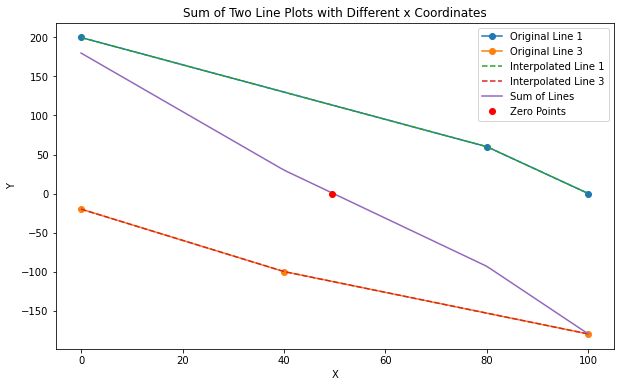

In [49]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# 示例数据
x1 = np.array([0,80,100])
y1 = np.array([200,60,0])

# x2 = np.array([0,60,100])
# y2 = np.array([120,80,40])

x3 = np.array([0,40,100])
y3 = np.array([-20,-100,-180])

# x4 = np.array([0,70,100])
# y4 = np.array([0,-80,-150])

# 创建公共x坐标
x_common = np.linspace(0, 100, 100)

# 插值
interp1 = interp1d(x1, y1, kind='linear', fill_value="extrapolate")
# interp2 = interp1d(x2, y2, kind='linear', fill_value="extrapolate")
interp3 = interp1d(x3, y3, kind='linear', fill_value="extrapolate")
# interp4 = interp1d(x4, y4, kind='linear', fill_value="extrapolate")

y1_interp = interp1(x_common)
# y2_interp = interp2(x_common)
y3_interp = interp3(x_common)
# y4_interp = interp4(x_common)

# 将插值后的y值相加
y_sum = y1_interp + y3_interp

# 找到组合后零点
# 使用差值法找到零点
zero_crossings = np.where(np.diff(np.sign(y_sum)))[0]
x_zeros = x_common[zero_crossings]
print(x_zeros)

# 创建一个新的图表
plt.figure(figsize=(10, 6))

# 绘制原始折线图
plt.plot(x1, y1, 'o-', label='Original Line 1')
# plt.plot(x2, y2, 'o-', label='Original Line 2')
plt.plot(x3, y3, 'o-', label='Original Line 3')
# plt.plot(x4, y4, 'o-', label='Original Line 4')

# 绘制插值后的折线图
plt.plot(x_common, y1_interp, '--', label='Interpolated Line 1')
# plt.plot(x_common, y2_interp, '--', label='Interpolated Line 2')
plt.plot(x_common, y3_interp, '--', label='Interpolated Line 3')
# plt.plot(x_common, y4_interp, '--', label='Interpolated Line 4')

# 绘制相加后的折线图
plt.plot(x_common, y_sum, label='Sum of Lines', linestyle='-')

# 绘制零点
plt.plot(x_zeros, np.zeros_like(x_zeros), 'ro', label='Zero Points')

# 添加图例
plt.legend()

# 添加标题和标签
plt.title('Sum of Two Line Plots with Different x Coordinates')
plt.xlabel('X')
plt.ylabel('Y')

# 显示图表
plt.show()

In [92]:
import Algorithm_noblock